## Multiclass Classification on Fashion MNIST Dataset

In this blog we will be performing multiclass classification on the [Fashion MNIST dataset](https://en.wikipedia.org/wiki/Fashion_MNIST). The dataset contains 60,000 images for training and 10,000 images for validation of 10 different types of fashion products. Multiclass classification is a classification task with more than two classes. Each sample can only be labeled as one class. For example, in the context of fashion-mnist images, each image can be of either a shirt, a sneaker, or a trouser. Each image is one sample and is labeled as one of the 10 possible classes. Multiclass classification makes the assumption that each sample is assigned to one and only one label - one sample cannot, for example, be both a shirt and a coat.

We will be performing the following tasks in this blog - 
* Import, analyze, and visualize the fashion-mnist dataset.
* Prepare the data for classification 
    + Principal Component Analysis 
    + Hyperparameter Tuning with Randomized Search
* Train a RandomForestClassifier and visualize its performance metrics
* Observations and Conclusion

Let us begin by importing a few packages and loading the data into a pandas dataframe. 

### 1. Import, analyze, and visualize the fashion-mnist dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(category=UserWarning, action='ignore')

In [2]:
# Load the train and test datasets
fmnist_train_df = pd.read_csv("data/fashion_mnist_train.csv")
fmnist_test_df = pd.read_csv("data/fashion_mnist_test.csv")

In [3]:
print(f'Train Set Dimensions - {fmnist_train_df.shape}')
print(f'Test Set Dimensions - {fmnist_test_df.shape}')

Train Set Dimensions - (60000, 785)
Test Set Dimensions - (10000, 785)


Let us print a few records from the training set and see how the data looks like. 

In [4]:
fmnist_train_df.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


We can see that most of the data is 0 with few values here and there. That is because each row is a 28 * 28 pixel image flattened into an [784,] array. Each element con contain a value between 0 and 255. Furthermore, the target feature named as label is having values from 0 to 9. We will have to process this column a little bit, to make more sense in the context of fashion products that we need to predict. We will see how to do that in just a bit, but first, let us try to reshape the images into 28 * 28 and try to visualize them using the matplotlib subplots.  

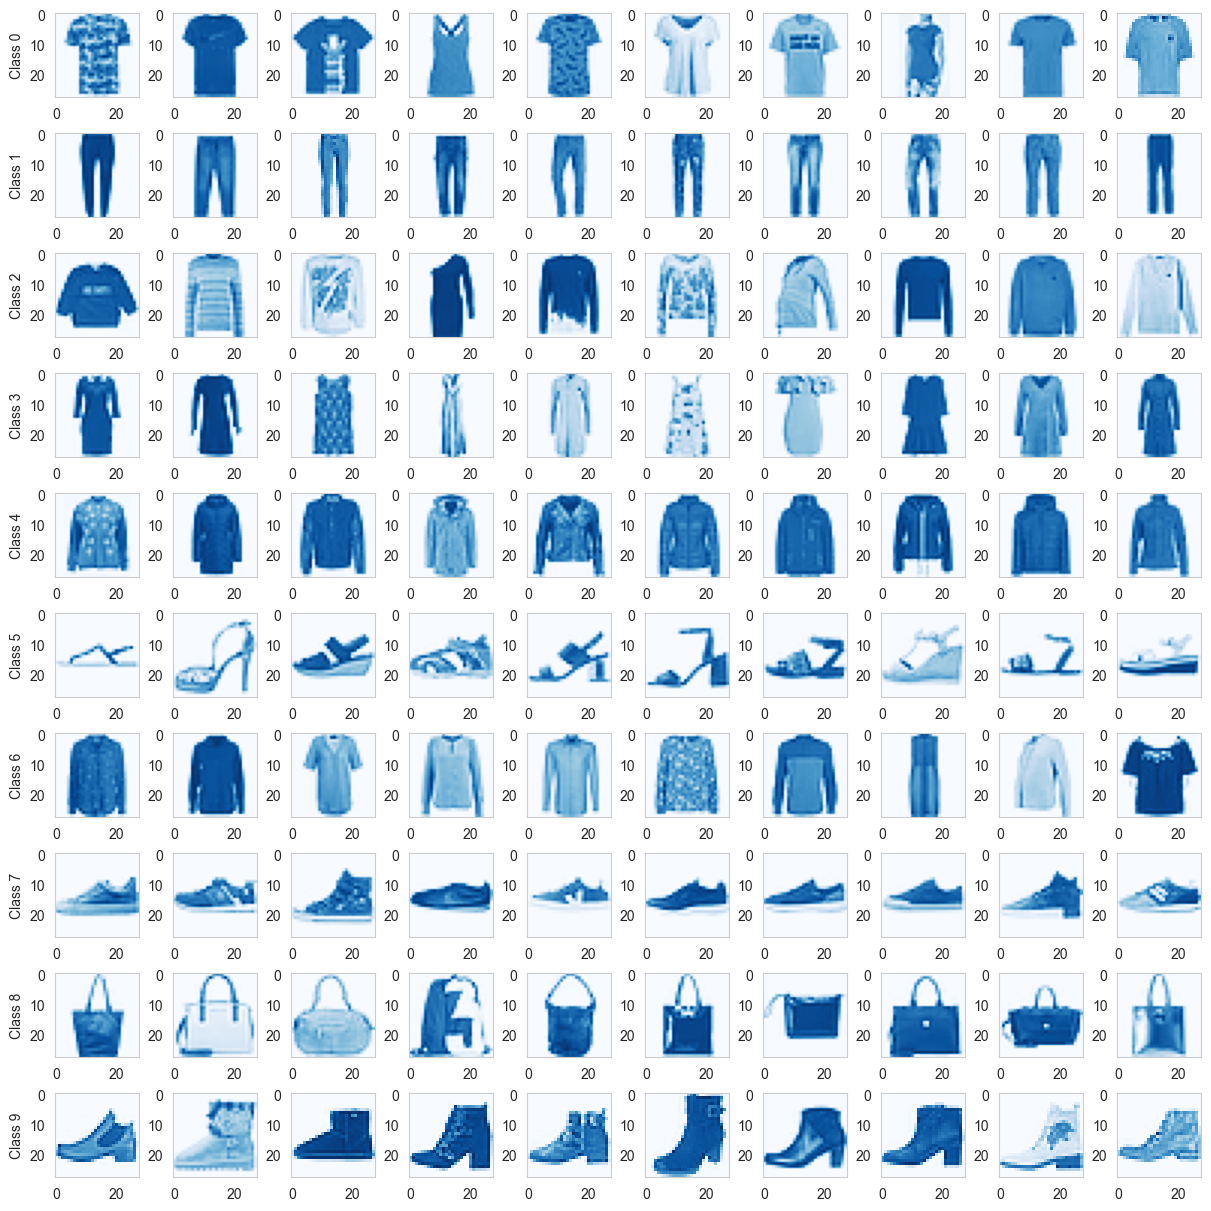

In [5]:
# Visualize the Images in the Dataset
labels_list = list(fmnist_train_df['label'].unique())
labels_list.sort()
fig, axs = plt.subplots(10, 10, figsize=(12, 12), layout='constrained')
for i in range(0, 10):
    class_df = fmnist_train_df[fmnist_train_df['label'] == labels_list[i]]
    for j in range(0, 10):
        sample_image = class_df.iloc[j, 1:].values.reshape(28, 28)
        axs[i][j].imshow(sample_image, cmap='Blues')
        axs[i][j].grid(False)
        if j == 0: axs[i][j].set_ylabel(f"Class {labels_list[i]}")
plt.grid(False)
plt.show()

We can see from the above plot different kinds of fashion products in the dataset. An obvious difficulty our multiclass classification algorith may face is the close resemblance of three different classes - class 0, class 2, and class 6. Fashion MNIST labels these classes as T-shirt/Top, Pullover, and Shirt respectively. To make target classes clear for us going forward, let us write a helper function that maps, the respective class number to its corresponding label. 

In [6]:
# Create more descriptive labels
def label_mapper(input):
    match input:
        case 0:
            return 'T-shirt/top'
        case 1:
            return 'Trouser'
        case 2:
            return 'Pullover'
        case 3:
            return 'Dress'
        case 4:
            return 'Coat'
        case 5:
            return 'Sandal'
        case 6:
            return 'Shirt'
        case 7:
            return 'Sneaker'
        case 8:
            return 'Bag'
        case 9:
            return 'Ankle boot'

fmnist_train_df['label'] = fmnist_train_df['label'].apply(lambda x:label_mapper(x))
fmnist_test_df['label'] = fmnist_test_df['label'].apply(lambda x:label_mapper(x))

Let us visualize if these changes took effect in the label column by printing a few values.

In [7]:
fmnist_train_df['label'].head(10)

0       Pullover
1     Ankle boot
2          Shirt
3    T-shirt/top
4          Dress
5           Coat
6           Coat
7         Sandal
8           Coat
9            Bag
Name: label, dtype: object

### 2. Prepare the data for classification

In [8]:
# Split the data into predictors (features) and target (label) in train and test sets
X_train = fmnist_train_df.iloc[:, 1:]
X_test = fmnist_test_df.iloc[:, 1:]
y_train = fmnist_train_df['label'].values
y_test = fmnist_test_df['label'].values

We already have the training and test set split for us. So let us just separate the predictor and target variables into matrix X (actually pandas DataFrame) and vector y (a pandas series) from training and test set. We will beusing the X_train and y_train to fit a classification model. We will then be using y_test to make prediction on samples that are unseen by the trained multiclass classification model. Finally, we will use y_test to evaluate our model.

Before we get ahead to the model, we will need to do some preprocessing. Image classification is a computationally expensive task and training 60,000 images each of 28*28 pixels can take significant of computing resources and training time. Furthermore, we do not have to invest as much resources, because very often only a portion of the images are useful for training. Take for example, in the below image of a pullover, a RandomForestClassifier trained on training data of 1000 samples, showing the important pixels in the image.  

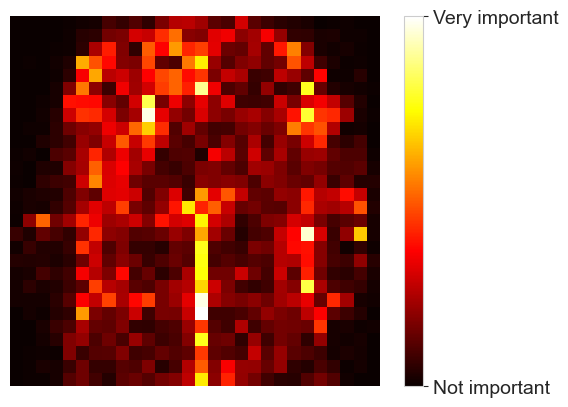

In [9]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100)
rnd_clf.fit(X_train[:1000], y_train[:1000])

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

### 2.1 Principal Component Analysis

An amazingly helpful strategy to reduce the number of features in the dataset is [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). PCA is a dimensionality reduction technique, that transforms the original feature space into a reduced feature space of orthogonal components such that the transformed feature space retains as much variance as possible from the original space. This transformed coordinate system for the principal components. The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. The i-th principal component can be taken as a direction orthogonal to the first i-1 principal components that maximizes the variance of the projected data. 

It can be shown that the principal components are eigenvectors of the data's covariance matrix. Thus, the principal components are often computed by eigendecomposition of the data covariance matrix or [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) of the data matrix. In SVD, we will start from the original data matrix X which has samples in rows and measured variables in columns. The SVD decomposition breaks this matrix X into three matrices - 

$$ X(n × p) = U_(n × p) * D_(p × p) * V^T_(p × p) $$ 


Where, 
- X contains the original data
- The columns of U are vectors giving the principal axes. These define the new coordinate system.
- The scores can be obtained by XV; scores are the projections of the data on the principal axes.
- D is a diagonal matrix, which means all non-diagonal elements are zero. The diagonal contains positive
values sorted from largest to smallest. These are called the singular values.
- The columns of V are the PCA loadings

In addition, U and V are semi-orthogonal matrices, which means that when pre-multiplied by their transpose
one gets the identity matrix:

$$ U^T * U = I $$
$$ V^T * V = I $$

To reduce the number of features from 784, We will perform PCA on the fashion-mnist dataset. Before we do that we need to scale our data. PCA assumes that data is normally distributed and is sensitive to the variance of variables, so we scale the data to ensure all variables are on the same scale. This also improves the performance of the algorithm and its prediction accuracy.   

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ncomponents_95_variance = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of Components needed for 95% Variance - {ncomponents_95_variance}")

Number of Components needed for 95% Variance - 256


To above step, creates an instance of StandardScaler and fits and transforms the trianing images. The test images are then scaled. The next part performs a full PCA analysis on the training set and calculates the cumulative explained variance - this is the sum of variance by individual principal components. As we can see, to retain 95% of the variance in the dataset, we need just 256 features. It is now computationally manageable for us to train the classifier using a subset of features. One drawback of PCA however is that, it does not tell us which features to retain and which to drop. That is why we will rely on a powerful classifier like **RandomForestClassifier**, which supports **feature sampling.**

Before that, let me show you a very useful plot that will allow you to visualize the number of components versus the explained variance. This plot allows you to see, how many components you need to retain certain amount of variance in the reduced feature space. For example, in the below plot you can see that, we need only 150 features to explain 91% of the variance in the data. We can build a pretty good model with that variance and strong classifier. 

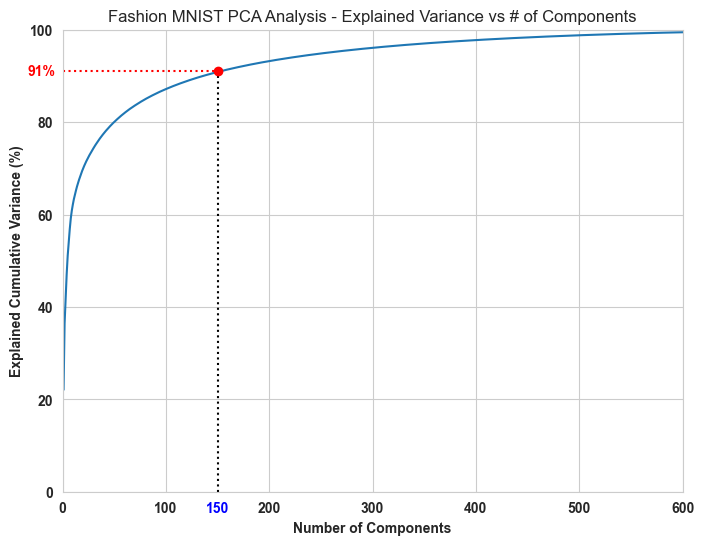

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1, 1), np.cumsum(pca.explained_variance_ratio_)*100)
plt.plot([150, 150], [0, 91], "k:")
plt.plot([0, 150], [91, 91], "r:")
plt.plot(150, 91, "ro")
plt.text(x=-20, y=91, s='91%', color='red', weight='bold', ha='center', va='center')
plt.text(x=150, y=-3.5, s='150', color='blue', weight='bold', ha='center', va='center')
plt.axis([0, 600, 0, 100])
plt.title("Fashion MNIST PCA Analysis - Explained Variance vs # of Components")
plt.xlabel("Number of Components", weight='bold')
plt.ylabel("Explained Cumulative Variance (%)", weight='bold')
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.grid(which='major', linestyle='-')
plt.show()

### 2.2 Hyperparameter Tuning with Randomized Search

We can also use hyperparameter tuning to search for best parameters. This is called [Hyperparameter Optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) or Hyperparameter Tuning. Scikit learn's **GridSearchCV** or **RandomizedSearchCV** can help with hyperparameter tuning. We can get the best values for number of components from principal component analysis and number of estimators from RandomForestClassifier using these methods. RandomizedSearchCV is preferred over GridSearchCV when there are many parameter values to try out. In contrast to GridSearchCV, RandomizedSearchCV tries not all parameter values but rather a fixed number of parameter settings sampled from the specified distributions making the search for best parameters quicker.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

preprocess_pipeline = make_pipeline(PCA(random_state=5805), RandomForestClassifier(random_state=5805))
params_distribution = {
    "pca__n_components": np.arange(50, 250), 
    "randomforestclassifier__n_estimators": np.arange(100, 400)
}
randomized_search = RandomizedSearchCV(preprocess_pipeline, params_distribution, n_iter=10, cv=3, random_state=5805)
randomized_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=5805)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=5805))]),
                   param_distributions={'pca__n_components': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,...
       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
       321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399])},
                   random_state=5805)

We can then use the **best_params_** attribute from the model to see the parameters that give best results. Note that above I have performed the search on 1000 training instances. Fell free to try and train on more instances. As you can see below, the number of estimators (desision tree classifiers) required by RandomForestClassifier are 197 and number of features are 234. 

In [13]:
randomized_search.best_params_

{'randomforestclassifier__n_estimators': 197, 'pca__n_components': 234}

### 3. Train a RandomForestClassifier and visualize its performance metrics

Using this analysis and hyperparameters, let us now proceed to train the classifier. We will use the n_estimators in RandomForestClassifier to be 197 and fit method to train the classifier. We will use the predict method of the classifier to get the predictions the classifier will make on the dataset. Let us store them in y_pred which we can later use for evaluating the classifier. 

In [14]:
# Perform PCA Transform with above n_components
pca = PCA(n_components=234, random_state=5805)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [15]:
# Train classifier
random_forest_classifier = RandomForestClassifier(n_estimators=197, random_state=5805)
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)

Now that we have trained our model and obtained the predictions from it for the test set. It is time to evaluate its performance. A very useful tool for evaluating the multiclass classification model is the **classification_report** from the sklearn metrics module. It gives us the precision, recall, and f1-score for each class. It also gives the overall f1-score of the classifier and a few other metrics we will discuss in just a second. We can extract the classification_report as follows -

In [16]:
from sklearn.metrics import classification_report

print(
    f"Classification report for {random_forest_classifier}:\n"
    f"{classification_report(y_test, y_pred)}\n"
)

Classification report for RandomForestClassifier(n_estimators=197, random_state=5805):
              precision    recall  f1-score   support

  Ankle boot       0.89      0.94      0.92      1000
         Bag       0.93      0.97      0.95      1000
        Coat       0.79      0.87      0.83      1000
       Dress       0.88      0.92      0.90      1000
    Pullover       0.80      0.79      0.80      1000
      Sandal       0.93      0.90      0.92      1000
       Shirt       0.74      0.57      0.65      1000
     Sneaker       0.90      0.88      0.89      1000
 T-shirt/top       0.79      0.84      0.82      1000
     Trouser       0.99      0.96      0.98      1000

    accuracy                           0.87     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.86      0.87      0.86     10000


So how do we read this classification report? Let us first define each of the metrics. 

 - **Precision** - In a multi-class classification task, the precision for a class is the number of true positives (i.e. the number of images correctly labelled as belonging to the positive class) divided by the total number of elements labelled as belonging to the positive class (i.e. the sum of true positives and false positives, which are images incorrectly labelled as belonging to the class).

$$ {\displaystyle \mathrm {PPV} ={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}=1-\mathrm {FDR} } $$

 - **Recall** - Recall in this context is defined as the number of true positives divided by the total number of images that actually belong to the positive class (i.e. the sum of true positives and false negatives, which are images which were not labelled as belonging to the positive class but should have been).

$$ {\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} } $$

 > Precision and recall are not particularly useful metrics when used in isolation. The need to be used in conjunction with other metrics to obtain a comprehensive evaluation of the model’s performance. For instance, A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it’s most confident about. If this one prediction is correct, then the classifier has 100% precision. Such a classifer would not be any helpful. Likewise, it is possible to have perfect recall by simply retrieving every single item. 
 - **F1-score and Accuracy** - The F1-score is a metric that combines precision and recall to obtain a balanced classification model. The F1 score favors classifiers that have similar precision and recall. It is calculated as the harmonic mean of precision and recall. Accuracy is another metric that measures the proportion of correct predictions made by the model.

**F1 Score**
$$ {\displaystyle \mathrm {F} _{1}=2\times {\frac {\mathrm {PPV} \times \mathrm {TPR} }{\mathrm {PPV} +\mathrm {TPR} }}={\frac {2\mathrm {TP} }{2\mathrm {TP} +\mathrm {FP} +\mathrm {FN} }}} $$

**Accuracy (ACC)**
$$ {\displaystyle \mathrm {ACC} ={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {P} +\mathrm {N} }}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {TN} +\mathrm {FP} +\mathrm {FN} }}} $$

Anathor important tool to evaluate the classifier is the **Confusion Matrix**, in the multi-class classification context, it gives the actual predictions in horizontal rows and predicted classes in vertical columns. We can use the ConfusionMatrixDisplay from scikit learn's metrics module to plot the confusion matrix for the classifier.  

Confusion matrix:
[[944   0   0   0   0  20   0  36   0   0]
 [  0 975   4   4   4   2   7   2   2   0]
 [  0   8 868  24  51   0  49   0   0   0]
 [  0   3  24 922   8   0  14   0  24   5]
 [  0  13 117  10 788   1  57   0  14   0]
 [ 36   6   0   0   0 902   0  56   0   0]
 [  0  25  82  23 113   0 575   0 182   0]
 [ 76   1   0   0   0  41   0 882   0   0]
 [  1  20   4  40  13   5  71   1 844   1]
 [  1   1   3  20   4   0   4   0   3 964]]


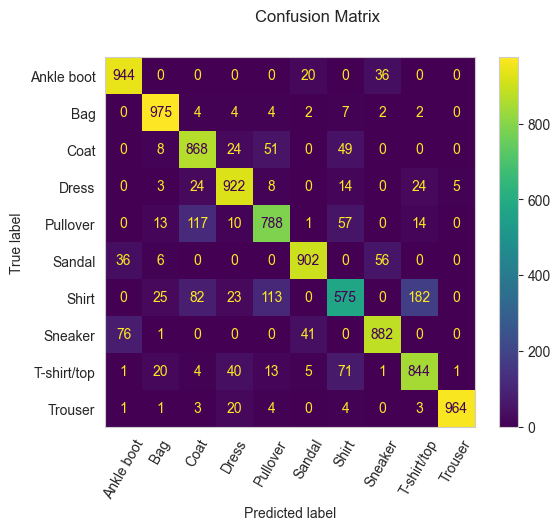

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.grid(False)
plt.xticks(rotation=60)
plt.show()

We can normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the row’s sum). This helps us to see where the model has misclassfied the images of a given class as belonging to different class. 

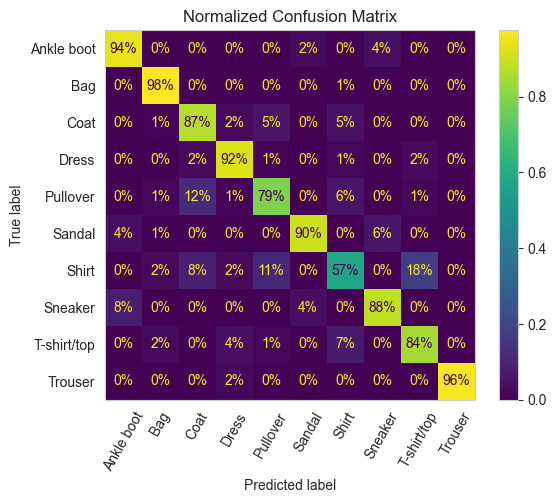

In [20]:
# Plot the normalized confused matrix.
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format=".0%")
plt.grid()
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=60)
plt.show()

### 4. Observations and Conclusion

Looking at the classification report, ROC Curve, and confusion matrix, we can make following observations -

The precision for "coat", "shirt", "pullover", and "T-shirt/top" is very low. This tells us that the model is predicting many False Positives for these classes. This is because these four classes are closely resembling one another. The classifier is unable to tell apart confidently a "coat" from a "shirt" and is resulting in many false positives and low precision. One way to improve the model precision for these labels is to increase the number of samples so that model can learn the subtle differences to tell apart each of these classes.

The recall for shirt is very low 57%. This tells that many images of shirt have been misclassified as belonging to a different class. Looking at the normalized confusin matrix, we can see that 18% of shirts have been misclassified as T-Shirt/Top, 11% of the shirts have been misclassified as pullover and 8% as Coats. We can see the same issue with images of pullover and coat, they have been misclassified as these other similar looking products.